<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Multivariate Forecasting**

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

print('Tensorflow version %s' % tf.__version__)

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

Tensorflow version 2.4.1
time: 2.12 ms (started: 2021-05-15 11:52:56 +00:00)


## **Preprocess Data**

#### **Import & Preprocess Data**

In [181]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('https://raw.githubusercontent.com/deltorobarba/repo/master/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
time: 799 ms (started: 2021-05-15 12:21:58 +00:00)


In [182]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/timeseries.csv'
data = pd.read_csv(url)
series = data[['date', 'price1', 'price2']].rename(columns={"price1": "google", "price2": "apple"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
dataset = series.copy()
dataset.head()

,google,apple
date,,
2010-02-01,265.51,280.42
2010-02-02,264.57,285.87
2010-02-03,269.40,279.49
2010-02-04,262.41,282.35
2010-02-05,264.65,284.06


time: 301 ms (started: 2021-05-15 12:21:59 +00:00)


#### **Visualize Dataset**

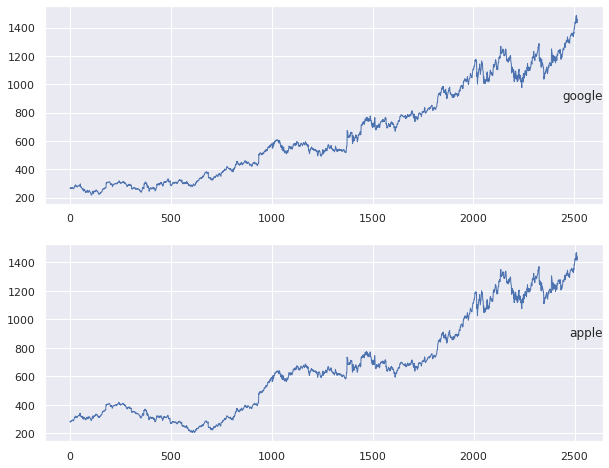

time: 287 ms (started: 2021-05-15 12:21:59 +00:00)


In [183]:
sns.set(rc={'figure.figsize':(10, 8), "lines.linewidth": 1.0})

# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### **LSTM Preprocess Dataset**

In [184]:
windows = 3
features = 2

time: 860 µs (started: 2021-05-15 12:21:59 +00:00)


In [185]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

time: 14.1 ms (started: 2021-05-15 12:21:59 +00:00)


In [186]:
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

time: 1.75 ms (started: 2021-05-15 12:21:59 +00:00)


In [187]:
# ensure all data is float
values = values.astype('float32')

time: 1.93 ms (started: 2021-05-15 12:21:59 +00:00)


In [188]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

time: 3.78 ms (started: 2021-05-15 12:21:59 +00:00)


In [189]:
# frame as supervised learning
reframed = series_to_supervised(scaled, windows, 1)

time: 10.4 ms (started: 2021-05-15 12:21:59 +00:00)


In [190]:
# Display data
reframed [:5]

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.038041,0.057941,0.037300,0.062260,0.041105,0.057204,0.035599,0.059470
4,0.037300,0.062260,0.041105,0.057204,0.035599,0.059470,0.037363,0.060825
5,0.041105,0.057204,0.035599,0.059470,0.037363,0.060825,0.038222,0.062482
6,0.035599,0.059470,0.037363,0.060825,0.038222,0.062482,0.039388,0.062181
7,0.037363,0.060825,0.038222,0.062482,0.039388,0.062181,0.038608,0.063441


time: 27.2 ms (started: 2021-05-15 12:21:59 +00:00)


In [191]:
# Show last column (to be removed)
num_rows, num_cols = reframed.shape
n = print (num_cols)
n

8
time: 3.13 ms (started: 2021-05-15 12:21:59 +00:00)


In [192]:
# drop columns we don't want to predict
n = 7 # number of last column (from above) minus 1 (the index column)
reframed.drop(reframed.columns[[n]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.038041   0.057941   0.037300   0.062260   0.041105   0.057204  0.035599
4   0.037300   0.062260   0.041105   0.057204   0.035599   0.059470  0.037363
5   0.041105   0.057204   0.035599   0.059470   0.037363   0.060825  0.038222
6   0.035599   0.059470   0.037363   0.060825   0.038222   0.062482  0.039388
7   0.037363   0.060825   0.038222   0.062482   0.039388   0.062181  0.038608
time: 18.8 ms (started: 2021-05-15 12:21:59 +00:00)


#### **Shape for LSTM**

In [193]:
# how many rows (time stamps)?
reframed.shape[0]

2512

time: 4.27 ms (started: 2021-05-15 12:22:00 +00:00)


In [194]:
values = reframed.values
train_time = 2000
train = values[:train_time, :]
test = values[train_time:, :]

time: 2.18 ms (started: 2021-05-15 12:22:00 +00:00)


In [195]:
# split into input and outputs
n_obs = windows * features
train_X, train_y = train[:, :n_obs], train[:, -features]
test_X, test_y = test[:, :n_obs], test[:, -features]
print(train_X.shape, len(train_X), train_y.shape)

(2000, 6) 2000 (2000,)
time: 5.31 ms (started: 2021-05-15 12:22:00 +00:00)


In [196]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], windows, features))
test_X = test_X.reshape((test_X.shape[0], windows, features))

time: 1.94 ms (started: 2021-05-15 12:22:00 +00:00)


In [197]:
print(test_X.shape, len(test_X), test_y.shape)

(512, 3, 2) 512 (512,)
time: 2.04 ms (started: 2021-05-15 12:22:00 +00:00)


In [198]:
test_X

array([[[0.6974705 , 0.72154284],
        [0.6997629 , 0.73530084],
        [0.7129499 , 0.73539597]],

       [[0.6997629 , 0.73530084],
        [0.7129499 , 0.73539597],
        [0.712556  , 0.7439867 ]],

       [[0.7129499 , 0.73539597],
        [0.712556  , 0.7439867 ],
        [0.72060686, 0.74274254]],

       ...,

       [[0.99822754, 0.99993664],
        [0.9994485 , 0.99999994],
        [1.        , 0.98370594]],

       [[0.9994485 , 0.99999994],
        [1.        , 0.98370594],
        [0.9842921 , 0.95722014]],

       [[1.        , 0.98370594],
        [0.9842921 , 0.95722014],
        [0.95844597, 0.97151715]]], dtype=float32)

time: 5.32 ms (started: 2021-05-15 12:22:00 +00:00)


## **Model Fitting & Forecasting**

#### **Create & Train Model**

In [199]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

time: 269 ms (started: 2021-05-15 12:22:00 +00:00)


In [200]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 11,121
Trainable params: 11,121
Non-trainable params: 0
_________________________________________________________________
time: 8.57 ms (started: 2021-05-15 12:22:00 +00:00)


In [201]:
# fit network
history = model.fit(train_X, train_y, 
                    epochs=20, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=1, 
                    shuffle=False)

Epoch 1/20
28/28 [==============================] - 2s 27ms/step - loss: 0.0757 - val_loss: 0.0589
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1105 - val_loss: 0.0983
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0356
Epoch 4/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.0415
Epoch 5/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0237 - val_loss: 0.0288
Epoch 6/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.0339
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0176 - val_loss: 0.0289
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0399
Epoch 9/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0412
Epoch 10/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0140
Epoch 11/20
28/28 

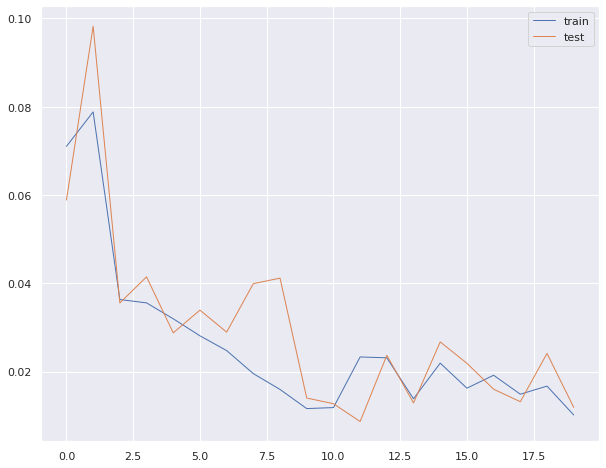

time: 301 ms (started: 2021-05-15 12:22:05 +00:00)


In [202]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### **Make a prediction**

In [203]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], windows*features))

time: 369 ms (started: 2021-05-15 12:22:05 +00:00)


In [204]:
# Shape: 6 windows (3 timesteps for 2 features)
test_X.shape[0], test_X.shape[1]

(512, 6)

time: 3.86 ms (started: 2021-05-15 12:22:05 +00:00)


In [205]:
test_X [0:5]

array([[0.6974705 , 0.72154284, 0.6997629 , 0.73530084, 0.7129499 ,
        0.73539597],
       [0.6997629 , 0.73530084, 0.7129499 , 0.73539597, 0.712556  ,
        0.7439867 ],
       [0.7129499 , 0.73539597, 0.712556  , 0.7439867 , 0.72060686,
        0.74274254],
       [0.712556  , 0.7439867 , 0.72060686, 0.74274254, 0.7188817 ,
        0.7493521 ],
       [0.72060686, 0.74274254, 0.7188817 , 0.7493521 , 0.7249632 ,
        0.7643464 ]], dtype=float32)

time: 5.16 ms (started: 2021-05-15 12:22:05 +00:00)


In [206]:
# Shape: one timestep forecasted for one feature
yhat.shape[0], yhat.shape[1]

(512, 1)

time: 4.33 ms (started: 2021-05-15 12:22:05 +00:00)


In [207]:
yhat [0:5]

array([[0.7368274 ],
       [0.7444753 ],
       [0.7469459 ],
       [0.75164706],
       [0.75804156]], dtype=float32)

time: 4.49 ms (started: 2021-05-15 12:22:05 +00:00)


## **Postprocess Data**

#### **Invert Scaling for Forecasted Test Data**

In [208]:
# remove all other features to align matrix structure
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat [0:5]

array([[0.7368274 , 0.73539597],
       [0.7444753 , 0.7439867 ],
       [0.7469459 , 0.74274254],
       [0.75164706, 0.7493521 ],
       [0.75804156, 0.7643464 ]], dtype=float32)

time: 10 ms (started: 2021-05-15 12:22:05 +00:00)


In [209]:
inv_yhat.shape[0], inv_yhat.shape[1]

(512, 2)

time: 5.09 ms (started: 2021-05-15 12:22:06 +00:00)


In [210]:
inv_yhat = scaler.inverse_transform(inv_yhat)[:, [1]]
inv_yhat [0:5]

array([[1135.24],
       [1146.08],
       [1144.51],
       [1152.85],
       [1171.77]], dtype=float32)

time: 8.35 ms (started: 2021-05-15 12:22:06 +00:00)


In [211]:
inv_yhat = inv_yhat[:,0]

time: 940 µs (started: 2021-05-15 12:22:06 +00:00)


In [212]:
inv_yhat [0:5]

array([1135.24, 1146.08, 1144.51, 1152.85, 1171.77], dtype=float32)

time: 8.17 ms (started: 2021-05-15 12:22:06 +00:00)


#### **Invert Scaling for Actual Test Data**

In [213]:
# Display target data
test_y [0:5]

array([0.73539597, 0.7439867 , 0.74274254, 0.7493521 , 0.7643464 ],
      dtype=float32)

time: 10.4 ms (started: 2021-05-15 12:23:45 +00:00)


In [214]:
# Reshape target data to concatenate later
test_y = test_y.reshape((len(test_y), 1))
test_y [0:5]

array([[0.73539597],
       [0.7439867 ],
       [0.74274254],
       [0.7493521 ],
       [0.7643464 ]], dtype=float32)

time: 5.05 ms (started: 2021-05-15 12:23:47 +00:00)


In [215]:
# Display input data
test_X [0:5]

array([[0.6974705 , 0.72154284, 0.6997629 , 0.73530084, 0.7129499 ,
        0.73539597],
       [0.6997629 , 0.73530084, 0.7129499 , 0.73539597, 0.712556  ,
        0.7439867 ],
       [0.7129499 , 0.73539597, 0.712556  , 0.7439867 , 0.72060686,
        0.74274254],
       [0.712556  , 0.7439867 , 0.72060686, 0.74274254, 0.7188817 ,
        0.7493521 ],
       [0.72060686, 0.74274254, 0.7188817 , 0.7493521 , 0.7249632 ,
        0.7643464 ]], dtype=float32)

time: 5.98 ms (started: 2021-05-15 12:23:49 +00:00)


In [216]:
# Concatenate input & target data
### This is purely for demonstration !!

inv_y = concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y [0:5]

array([[0.73539597, 0.6974705 , 0.72154284, 0.6997629 , 0.73530084,
        0.7129499 , 0.73539597],
       [0.7439867 , 0.6997629 , 0.73530084, 0.7129499 , 0.73539597,
        0.712556  , 0.7439867 ],
       [0.74274254, 0.7129499 , 0.73539597, 0.712556  , 0.7439867 ,
        0.72060686, 0.74274254],
       [0.7493521 , 0.712556  , 0.7439867 , 0.72060686, 0.74274254,
        0.7188817 , 0.7493521 ],
       [0.7643464 , 0.72060686, 0.74274254, 0.7188817 , 0.7493521 ,
        0.7249632 , 0.7643464 ]], dtype=float32)

time: 6.44 ms (started: 2021-05-15 12:23:52 +00:00)


In [217]:
# Concatenate input & target data
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y [0:5]

array([[0.73539597, 0.73539597],
       [0.7439867 , 0.7439867 ],
       [0.74274254, 0.74274254],
       [0.7493521 , 0.7493521 ],
       [0.7643464 , 0.7643464 ]], dtype=float32)

time: 8.3 ms (started: 2021-05-15 12:23:59 +00:00)


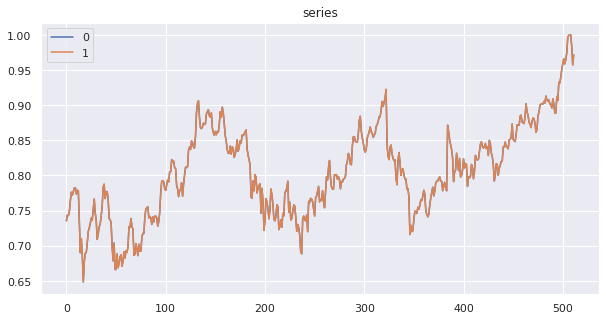

time: 359 ms (started: 2021-05-15 12:24:01 +00:00)


In [218]:
# testplot

df = pd.DataFrame(data=inv_y)
sns.set(rc={'figure.figsize':(10, 5)})
df.plot(title='series')

In [219]:
# Invert Scaling
inv_y = scaler.inverse_transform(inv_y)
inv_y [0:5]

array([[1150.7537, 1135.24  ],
       [1161.659 , 1146.08  ],
       [1160.0797, 1144.51  ],
       [1168.4701, 1152.85  ],
       [1187.5043, 1171.77  ]], dtype=float32)

time: 9.42 ms (started: 2021-05-15 12:24:16 +00:00)


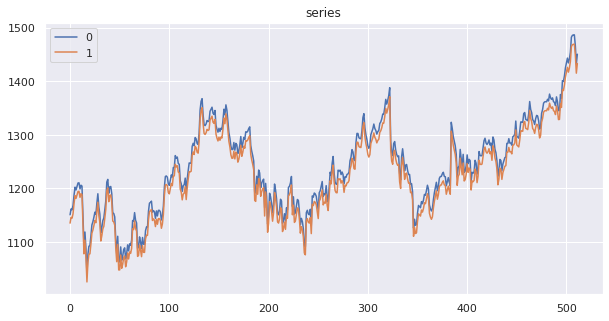

time: 360 ms (started: 2021-05-15 12:24:49 +00:00)


In [220]:
# testplot

df = pd.DataFrame(data=inv_y)
sns.set(rc={'figure.figsize':(10, 5)})
df.plot(title='series')

In [222]:
# Reshape again (transpose) and leave target data only (first column)
inv_y = inv_y[:,0]
inv_y [0:5]

array([1150.7537, 1161.659 , 1160.0797, 1168.4701, 1187.5043],
      dtype=float32)

time: 6.11 ms (started: 2021-05-15 12:30:58 +00:00)


## **Evaluate Model**

#### **Calculate RMSE**

In [223]:
# inv_y : Test Actual Target Data
# inv_yhat : Test Forecasted Target Data
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 16.05
time: 2.35 ms (started: 2021-05-15 12:31:00 +00:00)


In [226]:
df = concatenate((inv_y, inv_yhat))
df [0:5]

array([1150.7537, 1161.659 , 1160.0797, 1168.4701, 1187.5043],
      dtype=float32)

time: 6.56 ms (started: 2021-05-15 12:32:31 +00:00)


In [230]:
df1 = inv_y.reshape((len(inv_y), 1))
df1 [0:5]

array([[1150.7537],
       [1161.659 ],
       [1160.0797],
       [1168.4701],
       [1187.5043]], dtype=float32)

time: 5.47 ms (started: 2021-05-15 12:35:05 +00:00)


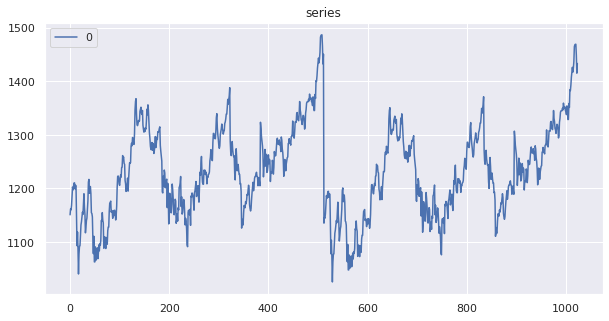

time: 338 ms (started: 2021-05-15 12:33:06 +00:00)


In [228]:
df = pd.DataFrame(data=df)
sns.set(rc={'figure.figsize':(10, 5)})
df.plot(title='series')

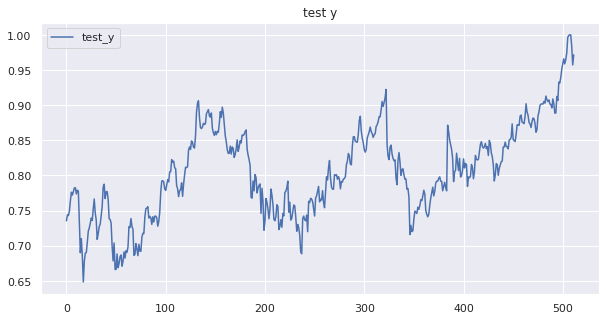

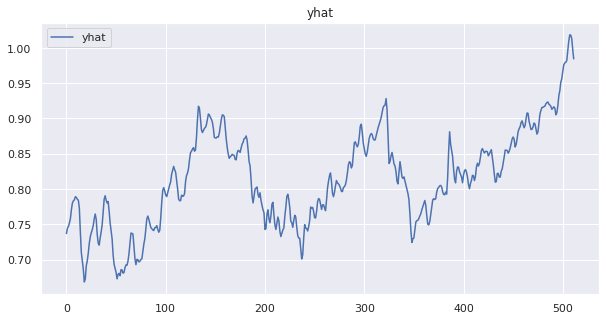

time: 663 ms (started: 2021-05-15 12:31:03 +00:00)


In [224]:
test_y_plot = pd.DataFrame(data=test_y, columns=['test_y'])
yhat_plot = pd.DataFrame(data=yhat, columns=['yhat'])

sns.set(rc={'figure.figsize':(10, 5)})
test_y_plot.plot(title='test y')
yhat_plot.plot(title='yhat')

#### **Residuals**

In [ ]:
# Get residuals (normalized)
residuals = (test_y[0] - yhat[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,-0.005307
1,-0.012515
2,-0.015052
3,-0.019509
4,-0.026277


time: 14.5 ms (started: 2021-05-15 07:15:14 +00:00)


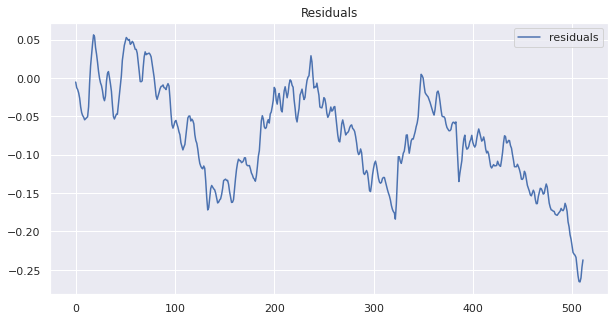

time: 384 ms (started: 2021-05-15 07:15:14 +00:00)


In [ ]:
# Plot Residuals
sns.set(rc={'figure.figsize':(10, 5)})
res.plot(title='Residuals')

#### **Plot Results**

In [ ]:
# Plot results

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[windows:len(yhat)+windows, :] = yhat

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(test_X)+(windows*2)+1:len(dataset)-1, :] = test_X

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: ignored

time: 29.6 ms (started: 2021-05-15 07:15:14 +00:00)
